# Gousto - Data Science Task
##### _Scott Hunter - 12/01/2020_

#### Quick exploratory data analysis

##### __Step 1:__ _Load dependencies and set display options_

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from matplotlib import pyplot as plt

In [2]:
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', None)

##### __Step 2:__ _Read in the SIMILARITY SCORE data as a pandas dataframe_

In [3]:
# Check for empty values
similarity_scores = pd.read_csv('.../similarity_scores.csv')
print(similarity_scores.isnull().sum())
print(similarity_scores.describe())

user_id       0
message_ts    0
action_ts     0
recipe_a      0
recipe_b      0
score         0
dtype: int64
            user_id     recipe_a     recipe_b        score
count   4338.000000  4338.000000  4338.000000  4338.000000
mean   10125.821116   392.556708   397.141079     1.590595
std       49.068311   161.032945   158.554734     0.834314
min    10001.000000     2.000000     2.000000     1.000000
25%    10127.000000   292.000000   292.000000     1.000000
50%    10141.000000   449.000000   449.000000     1.000000
75%    10145.000000   546.000000   546.000000     2.000000
max    10163.000000   590.000000   592.000000     4.000000


In [4]:
# Set arbitrary scalar values to use in re-weighting equation
scalar = {1 : -0.67, 2 : -0.33, 3 : 0.33, 4 : 0.66}     
similarity_scores['scalar'] = similarity_scores['score'].map(scalar)

In [5]:
# Derive score response 'labels' to use in re-weighting equation
response = {1 : 'very negative', 2 : 'negative', 3 : 'positive', 4 : 'very positive'}     
similarity_scores['response'] = similarity_scores['score'].map(response)

In [6]:
similarity_scores.head(5)

,user_id,message_ts,action_ts,recipe_a,recipe_b,score,scalar,response
0,10141,28/07/2016 15:22,28/07/2016 16:32,548,292,2,-0.33,negative
1,10163,11/08/2016 12:06,11/08/2016 12:08,584,288,1,-0.67,very negative
2,10163,15/08/2016 11:04,15/08/2016 11:11,288,553,3,0.33,positive
3,10011,20/08/2016 22:42,20/08/2016 22:43,271,498,2,-0.33,negative
4,10141,25/08/2016 10:38,25/08/2016 11:27,585,89,1,-0.67,very negative


In [7]:
# Show an example of how scores will be affected by our weight rules.

response_answer = ["very negative", "negative", "combination not surveyed", "positive", "very positive"]
response_scalar = [-0.67,-0.33,1,0.33,0.67]

# list of strings
data = {'score': [0.99,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.01]
        , 'very negative': [0.3267,	0.297,0.264,0.231,0.198,0.165,0.132,0.099,0.066,0.033,0.0033]
        , 'negative': [0.6633,0.603,0.536,0.469,0.402,0.335,0.268,0.201,0.134,0.067,0.0067]
        , 'combination not surveyed': [0.99,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.01]
        , 'positive': [0.9933,0.933,0.866,0.799,0.732,0.665,0.598,0.531,0.464,0.397,0.3367]
        , 'very positive': [0.9967,0.967,0.934,0.901,0.868,0.835,0.802,0.769,0.736,0.703,0.6733]}

df = pd.DataFrame(data)
df.set_index('score', inplace=True)

##### _Plotting arbitrary similarity scores against our 'weight' rules show how when the weights are applied, the relationship is linear but is programmed to increase/decrease by lots/not a lot depending on the scenario_ 
##### * _A given score for an unfeatured combination of recipes in the data is given a weight of 1 and therefore is not changed_
##### * _Low scores that receive a high similarity measure increase sharply, and low scores that receieve a low similarity measure a marginally discounted_
##### * _By comparison, high scores that receive a high similarity measure do not increase by much, while high scores that receieve a low similarity measure are massively re-weighted down_

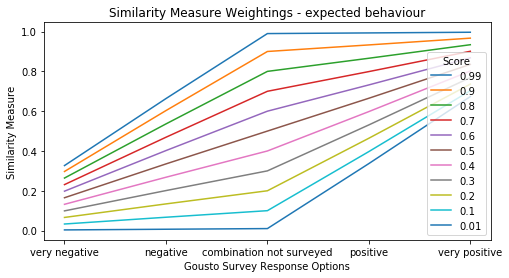

In [8]:
plt.figure(figsize=(8,4))
for i in range(len(df)):
    plt.plot(df.iloc[i,:], label = df.index[i])
    plt.legend(title="Score", loc=4)
    plt.xlabel('Gousto Survey Response Options'); plt.ylabel('Similarity Measure'); plt.title('Similarity Measure Weightings - expected behaviour');

##### __Step 3:__ _Read in the RECIPE DESCRIPTION data as a pandas dataframe and clean as required_

In [9]:
# Check for empty values
recipes = pd.read_csv('.../recipes_info.csv')
print(recipes.isnull().sum())

recipe_id                 0
country                   0
country_secondary         0
dish_category             8
dish_type                 0
diet_type                 0
carbohydrate_base         0
carbohydrate_category    30
protein                  36
protein_cut              19
protein_type             36
family_friendly           0
spice_level               0
prep_time                 0
dtype: int64


In [10]:
# Check for duplication
recipes[recipes["recipe_id"].isin(recipes["recipe_id"][recipes["recipe_id"].duplicated()])]

# Remove selected rows (where prep_time is not a range)
recipes = recipes.drop([26,73])

In [11]:
# Classify null values as an object value outcome as 'none'
recipes.fillna('none', inplace=True)

In [12]:
# Code all responses of the column into the same 'case' format
recipes['family_friendly'] = recipes['family_friendly'].str.lower()

In [13]:
# Use a dictionary to 'tidy' other categorical data noticed on first inspection of the .csv file

di = {# Remove duplications found
      "United States of America (USA)": "United States"
      
      # Group 'prep times' into broader ranges for consistency of outcomes
      , "10": "10-14"
      , "15": "15-19"
      , "20": "20-24"
      , "25": "25-29"
      , "30": "30-34"
      , "35": "35-39"
      , "40": "40-44"
      , "45": "45-49"
      , "50": "50-54"
      , "55": "55-59"
      , "60": "60+"}

recipes.replace({"country_secondary": di
                 , "country": di
                 , "prep_time": di}, inplace=True)

In [14]:
# Create a new column, that joins all the information together as 'text', excluding the recipe id, to later analyse
recipes_string = recipes[recipes.columns[1:]].apply(lambda x: ','.join(x.astype(str)), axis=1)

#### Solution 1: Count Vectorizer
##### _A vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the recipe string._

In [15]:
# Create array to count the frequency of terms (columns) across each row (reciple id)
count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer = CountVectorizer()
count_matrix = count_vectorizer.fit_transform(recipes_string)
count_matrix = count_matrix.todense()

In [16]:
# Display count results in a Pandas Dataframe, with all column datapoints as keyword columns and recipe id as the row index
df = pd.DataFrame(count_matrix)
df.reset_index(drop=True, inplace=True)
df2 = recipes[['recipe_id']].reset_index(drop=True)
df = pd.concat([df2,df],axis=1).set_index('recipe_id')

In [17]:
# Calculate the Cosine Similarity as the objective measure for this solution style
from sklearn.metrics.pairwise import cosine_similarity
my_solution_1_matrix = cosine_similarity(df, df)
print(my_solution_1_matrix)

[[1.         0.07698004 0.48007936 ... 0.10954451 0.49135381 0.27529888]
 [0.07698004 1.         0.08399211 ... 0.07027284 0.21821789 0.26490647]
 [0.48007936 0.08399211 1.         ... 0.07968191 0.32991444 0.3003757 ]
 ...
 [0.10954451 0.07027284 0.07968191 ... 1.         0.24152295 0.12565617]
 [0.49135381 0.21821789 0.32991444 ... 0.24152295 1.         0.26013299]
 [0.27529888 0.26490647 0.3003757  ... 0.12565617 0.26013299 1.        ]]


In [18]:
# Present as Recipe ID Cross-tab to show similarity values across all Pairwise combinations, publish as csv file
my_solution_1 = pd.DataFrame(cosine_similarity(df, df), index=recipes['recipe_id'], columns=recipes['recipe_id'])

In [19]:
my_solution_1.head(5)

recipe_id,2,5,9,16,19,...,1280,1281,1282,1283,1284
recipe_id,,,,,,,,,,,
2,1.000000,0.076980,0.480079,0.422116,0.188982,...,0.235339,0.482808,0.109545,0.491354,0.275299
5,0.076980,1.000000,0.083992,0.232104,0.181848,...,0.226455,0.250160,0.070273,0.218218,0.264906
9,0.480079,0.083992,1.000000,0.164488,0.164957,...,0.128388,0.202610,0.079682,0.329914,0.300376
16,0.422116,0.232104,0.164488,1.000000,0.227921,...,0.147828,0.363930,0.082572,0.256411,0.069171
19,0.188982,0.181848,0.164957,0.227921,1.000000,...,0.185312,0.070186,0.345033,0.321429,0.173422


#### Solution 2: TFIDF Vectorizer
##### _A vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the recipe string, but with penalties for the same words appearing over our recipes. I thought this appropriate for 'repeated' data such as in the country and second country columns._

In [20]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(recipes_string)
tfidf_matrix = tfidf_matrix.todense()

In [21]:
# Display count results in a Pandas Dataframe, with all column datapoints as keyword columns and recipe id as the row index
df = pd.DataFrame(tfidf_matrix)
df.reset_index(drop=True, inplace=True)
df2 = recipes[['recipe_id']].reset_index(drop=True)
df = pd.concat([df2,df],axis=1).set_index('recipe_id')

In [22]:
# Calculate the Cosine Similarity as the objective measure for this solution style
my_solution_2_matrix = cosine_similarity(df, df)
print(my_solution_2_matrix)

[[1.         0.01181816 0.30567048 ... 0.01802823 0.23370453 0.08455922]
 [0.01181816 1.         0.02697093 ... 0.0334011  0.1588473  0.20606155]
 [0.30567048 0.02697093 1.         ... 0.02679348 0.12353481 0.11069277]
 ...
 [0.01802823 0.0334011  0.02679348 ... 1.         0.14475651 0.04719625]
 [0.23370453 0.1588473  0.12353481 ... 0.14475651 1.         0.08326819]
 [0.08455922 0.20606155 0.11069277 ... 0.04719625 0.08326819 1.        ]]


In [23]:
# Present as Recipe ID Cross-tab to show similarity values across all Pairwise combinations, publish as csv file
my_solution_2 = pd.DataFrame(cosine_similarity(df, df), index=recipes['recipe_id'], columns=recipes['recipe_id'])

#### Solution 3: Hashing Vectorizer
##### _Applies a hashing function to term frequency counts._

In [24]:
hashing_vectorizer = HashingVectorizer()
hashing_matrix = hashing_vectorizer.fit_transform(recipes_string)
hashing_matrix = hashing_matrix.todense()

In [25]:
# Display count results in a Pandas Dataframe, with all column datapoints as keyword columns and recipe id as the row index
df = pd.DataFrame(hashing_matrix)
df.reset_index(drop=True, inplace=True)
df2 = recipes[['recipe_id']].reset_index(drop=True)
df = pd.concat([df2,df],axis=1).set_index('recipe_id')

In [26]:
# Calculate the Cosine Similarity as the objective measure for this solution style
my_solution_3_matrix = cosine_similarity(df, df)
print(my_solution_3_matrix)

[[1.         0.07698004 0.48007936 ... 0.10954451 0.49135381 0.27529888]
 [0.07698004 1.         0.08399211 ... 0.07027284 0.21821789 0.26490647]
 [0.48007936 0.08399211 1.         ... 0.07968191 0.32991444 0.3003757 ]
 ...
 [0.10954451 0.07027284 0.07968191 ... 1.         0.24152295 0.12565617]
 [0.49135381 0.21821789 0.32991444 ... 0.24152295 1.         0.26013299]
 [0.27529888 0.26490647 0.3003757  ... 0.12565617 0.26013299 1.        ]]


In [27]:
# Present as Recipe ID Cross-tab to show similarity values across all Pairwise combinations, publish as csv file
my_solution_3 = pd.DataFrame(cosine_similarity(df, df), index=recipes['recipe_id'], columns=recipes['recipe_id'])

##### _It seems solution 3 gave an identical answer to solution 1_ 

#### Final Solution: TFIDF Vectorizer with subjective similarity survey weights applied
##### _This method seems a more appropriate one given the data and the assumption that we use all columns. It will penalise cases of repeated terms but also do the job of the count vectorizer._

In [28]:
# Stack similarity matrix back into dataframe for further manipulation; rename indices and create 'key' for merging with subjective similarity scores dataset
my_solution = my_solution_2
my_solution.index.names = ['recipe_a']
my_solution = my_solution.stack().reset_index(name='similarity_score')
my_solution['key'] = my_solution["recipe_a"].map(str) + '_' + my_solution["recipe_id"].map(str)
my_solution.rename({'recipe_id': 'recipe_b'}, axis=1, inplace=True)

In [29]:
# Transform into the same format as our matrix for 
similarity_scores = similarity_scores.groupby(['recipe_a', 'recipe_b'])['scalar'].mean().reset_index()
similarity_scores['key'] = similarity_scores["recipe_a"].map(str) + '_' + similarity_scores["recipe_b"].map(str)

In [30]:
# Map 'responses' back onto 'average' values for our arbitrary weight numbers
similarity_scores['weight'] = np.where((similarity_scores['scalar'] >= -0.67) & (similarity_scores['scalar'] < -0.33), 'very negative',
                                         np.where((similarity_scores['scalar'] >= -0.33) & (similarity_scores['scalar'] < 0), 'negative',
                                                  np.where((similarity_scores['scalar'] > 0) & (similarity_scores['scalar'] <= 0.33), 'positive',
                                                           np.where((similarity_scores['scalar'] > 0.33) & (similarity_scores['scalar'] <= 0.66), 'very positive', 'not surveyed'))))

In [31]:
# Join similarity matrix and similarity scores together, fill in missing combinations from similarity scores data with 'not surveyed'; tidy
joined = pd.merge(my_solution, similarity_scores, on='key', how='left')
joined['weight'].fillna('not surveyed', inplace=True)
joined.drop(['recipe_a_y','recipe_b_y'], axis=1, inplace=True)
joined.rename({'recipe_a_x': 'recipe_a','recipe_b_x': 'recipe_b'}, axis=1, inplace=True)

In [32]:
# Re-map weights into the dataset to be used as scale factors for opinions on similar recipes
applied_scalar = {'very negative' : -0.67, 'negative' : -0.33, 'positive' : 0.33, 'very positive' : 0.66}
joined['applied_scalar'] = joined['weight'].map(applied_scalar)

In [33]:
# Apply equations to re-weight scores where applicable
joined['adjusted_similarity_score'] = np.where((joined['weight'] == 'very negative') | (joined['weight'] == 'negative'), joined['similarity_score'] + (joined['similarity_score'] * joined['applied_scalar']),
                                      np.where((joined['weight'] == 'very positive') | (joined['weight'] == 'positive'), joined['similarity_score'] + (1-joined['similarity_score']) * joined['applied_scalar'], joined['similarity_score']))

In [34]:
# Display results as crosstab
final_similarity_scores = pd.crosstab(joined.recipe_a
                                      , joined.recipe_b
                                      , values=joined.adjusted_similarity_score
                                      , aggfunc='max').round(2)

final_similarity_scores = final_similarity_scores.values
print(final_similarity_scores)

[[1.   0.01 0.31 ... 0.02 0.23 0.08]
 [0.01 1.   0.03 ... 0.03 0.16 0.21]
 [0.31 0.03 1.   ... 0.03 0.12 0.11]
 ...
 [0.02 0.03 0.03 ... 1.   0.14 0.05]
 [0.23 0.16 0.12 ... 0.14 1.   0.08]
 [0.08 0.21 0.11 ... 0.05 0.08 1.  ]]


In [35]:
my_solution = pd.DataFrame(final_similarity_scores, index=df2['recipe_id'], columns=df2['recipe_id'])
my_solution.index.names = ['recipe_a']
my_solution = my_solution.stack().reset_index(name='similarity_score')
my_solution = my_solution.rename({'recipe_id': 'recipe_b'}, axis=1)

In [36]:
# Top 10 most similar recipes
my_solution = my_solution.sort_values(by='similarity_score', ascending=False)
my_solution[my_solution['similarity_score'] != 1].head(10)

,recipe_a,recipe_b,similarity_score
36791,526,555,0.97
66210,1283,577,0.97
42052,577,1283,0.97
52044,1098,945,0.96
48189,945,1098,0.96
43689,874,399,0.96
22615,399,874,0.96
36723,526,399,0.96
22588,399,526,0.96
42360,584,313,0.94


In [37]:
# Derive a matrix that shows the largest movement of items between Vectorizer solution and influence of subjective similarity scores
diff_solution = np.subtract(final_similarity_scores, my_solution_2_matrix)
diff_solution = pd.DataFrame(diff_solution, index=df2['recipe_id'], columns=df2['recipe_id'])
diff_solution.index.names = ['recipe_a']
diff_solution = diff_solution.stack().reset_index(name='similarity_score')
diff_solution = diff_solution.sort_values('similarity_score')
diff_solution = diff_solution.rename({'recipe_id': 'recipe_b'}, axis=1)

In [38]:
# Top 10 combinations that 
print(diff_solution.head(10))

       recipe_a  recipe_b  similarity_score
39116       548       563         -0.463592
31373       470       555         -0.438199
38847       546       539         -0.412333
36687       526       317         -0.357801
13300       317       526         -0.357801
10999       288       580         -0.338570
9964        264       573         -0.337643
12289       305       580         -0.327495
42101       580       305         -0.327495
42218       580       584         -0.318958


In [39]:
# Top 10 combinations that 
print(diff_solution.tail(10))

       recipe_a  recipe_b  similarity_score
19209       359       463          0.445624
10590       285        89          0.459400
3137         89       285          0.459400
2485         57       580          0.491927
30470       464       197          0.494759
30608       464       584          0.511964
42430       584       464          0.511964
2592         58        89          0.587909
37161       529        57          0.615515
11212       292       464          0.650276


#### __Production Code:__ Final Solution wrapper (without weights)

In [40]:
class CLS_Recipe_Similarity(object):
    
    ### Load required libraries
    import pandas as pd
    import numpy as np
    from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
    from matplotlib import pyplot as plt
    
    """
    Parameters
    ----------    
       * Analysis Method: Apply a Count, Tfidf or Hashing Vectorizer
       * Dataframe: A list of recipes and their various attributes
       * Corpus: A transformation of the dataframe into a 'sentence'
       * ID Key: Primary Key of the data to summarise on
       * Weights: A simple mathematical transformation of subjective scores

    Return 
    ------
    numpy_matrix of simlarity scores for a given text corpus
    """
    
    # Initialise class with preferred similarity measure
    def __init__(self, analysis_method):
        self.analysis_method = analysis_method
    
    # Print class similarity measure
    def __repr__(self):
        return "Recipe Analysis Method Selected: " '{}'.format(self.analysis_method)

    # Transform dataframe into text corpus
    def create_recipe_corpus(self, df):
        corpus = df[df.columns[1:]].apply(lambda x: ','.join(x.astype(str)), axis=1)
        return corpus       
    
    ### Transform corpus into raw similarity matrix
    def raw_similarity_matrix(self, df, corpus, id_key):
        
        if self.analysis_method == 'Count':
            vectorizer = CountVectorizer(stop_words='english')
        
        elif self.analysis_method == 'TFIDF':
            vectorizer = TfidfVectorizer(stop_words='english')
        
        elif self.analysis_method == 'Hashing':
            vectorizer = HashingVectorizer(stop_words='english')

        matrix = vectorizer.fit_transform(corpus)
        matrix = matrix.todense()

        df_matrix = pd.DataFrame(matrix)
        df_matrix = pd.concat([df[[id_key]], df_matrix], axis=1).set_index(id_key)

        similarity_matrix = cosine_similarity(df_matrix, df_matrix)

        return similarity_matrix
    
    ### Transform raw similarity matrix into weighted similarity matrix

In [41]:
### Load in dataset
my_recipes = pd.read_csv('/data/h7836666/recipes_info.csv')
my_scores = pd.read_csv('/data/h7836666/similarity_scores.csv')

### Load and define Recipe Similarity Class, assign 
Recipe_Similarity = CLS_Recipe_Similarity(analysis_method = 'TFIDF')

### Print class attributes
print(Recipe_Similarity.__repr__())

### Transform recipe dataframe into text corpus
recipe_string = Recipe_Similarity.create_recipe_corpus(df = my_recipes)

### Transform recipe corpus into similarity matrix
raw_similarity_matrix = Recipe_Similarity.raw_similarity_matrix(df = my_recipes
                                                                , corpus = recipe_string
                                                                , id_key = 'recipe_id')
### Publish output
print('')
print('Raw Similarity Matrix: ')
print('----------------------')
print(raw_similarity_matrix)
print('')

Recipe Analysis Method Selected: TFIDF

Raw Similarity Matrix: 
----------------------
[[1.         0.         0.24518723 ... 0.00831713 0.20529246 0.05771647]
 [0.         1.         0.02414931 ... 0.02855636 0.1564317  0.21324391]
 [0.24518723 0.02414931 1.         ... 0.02336754 0.10400734 0.09736453]
 ...
 [0.00831713 0.02855636 0.02336754 ... 1.         0.13262437 0.01975253]
 [0.20529246 0.1564317  0.10400734 ... 0.13262437 1.         0.05474023]
 [0.05771647 0.21324391 0.09736453 ... 0.01975253 0.05474023 1.        ]]



#### Final thoughts and Improvements:
###### - Create more functions to avoid repitition of code
###### - Incorporate 'weights' steps into class function
###### - Subjective similarity scores contain instances of the same users giving different opinions on the same recipe combinations
###### - Many of the recipe combinations aren't scored; a question of whether it fair to re-weight those recipe combinations from this data when most do not get the chance to be re-weighted